In [1]:
from astropy.io import fits
from scipy import *
import numpy as np
from pylab import *
from astropy.coordinates import SkyCoord
import astropy.units as units
from IPython.display import Image
from astropy.coordinates import FK5, ICRS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import match_coordinates_sky
import WLanalysis
from scipy.interpolate import interp2d,NearestNDInterpolator
from scipy.interpolate import interp1d
import os
import utils
import spectral_model
import fitting


In [111]:
def read_spec(fitsfile):    
    ihdulist = fits.open(fitsfile)
    idate = ihdulist[0].header['DATE-OBS'][:10]
    ispec = ihdulist[1].data
    ierr = ihdulist[2].data
    imask = ihdulist[3].data
    ipass = ones(shape=imask.shape)
    for ibit in (0,1,2,3,4,5,6,7,12,13,14):
        ipass[~logical_not(imask & 2**ibit)]=0
    ilambda = ihdulist[4].data
    return ilambda, ispec, ierr, ipass, idate

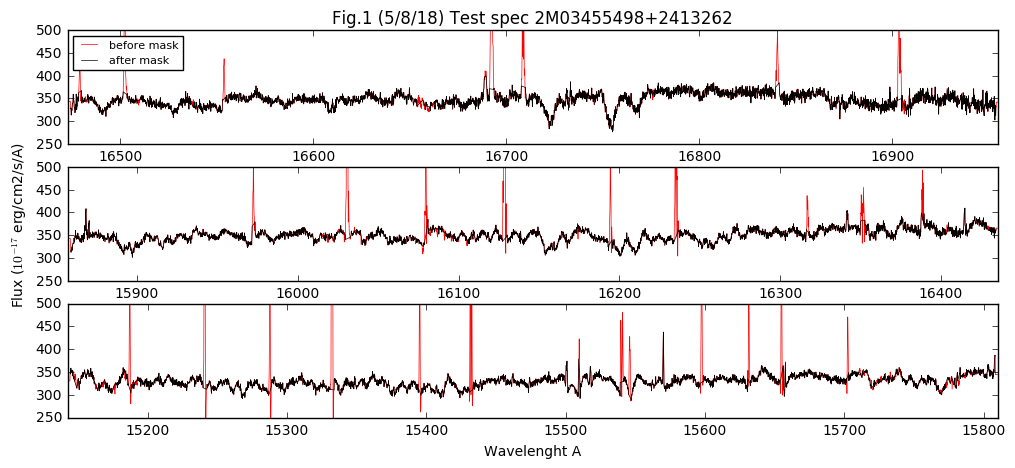

In [157]:
apodir = '/Users/jia/Dropbox/smbhs/ApogeeLine/'
apoid_candidates = os.listdir(apodir+'specs_visit')[1:]
iapoid = apoid_candidates[7]
ifitsfn = apodir+'specs_visit/%s/%s'%(iapoid,os.listdir(apodir+'specs_visit/%s'%(iapoid))[0])

ilambda, ispec, ierr, ipass, idate = read_spec(ifitsfn)
f, axes=subplots(3,1,figsize=(12,5))
for i in range(len(ilambda)):
    axes[i].plot(ilambda[i], ispec[i], 'r-',lw=0.5,label='before mask')
    axes[i].plot(ilambda[i][where(ipass[i])], ispec[i][where(ipass[i])], 'k-',lw=0.5,label='after mask')
    axes[i].set_xlim(amin(ilambda[i]),amax(ilambda[i]))
    axes[i].set_ylim(250,500)
axes[1].set_ylabel('Flux ($10^{-17}$ erg/cm2/s/A)') 
axes[-1].set_xlabel('Wavelenght A')
axes[0].set_title('Fig.1 (5/8/18) Test spec '+apoid_candidates[j])
axes[0].legend(fontsize=8,loc='best')
show()
#print imask[1]

In [137]:
#from __future__ import absolute_import, division, print_function # Python2 compatibility
os.chdir(apodir+'binspec')
# read in all individual neural networks we'll need. 
NN_coeffs_norm = utils.read_in_neural_network(name = 'normalized_spectra')
NN_coeffs_flux = utils.read_in_neural_network(name = 'unnormalized_spectra')
NN_coeffs_R = utils.read_in_neural_network(name = 'radius')
NN_coeffs_Teff2_logg2 = utils.read_in_neural_network(name = 'Teff2_logg2')
wavelength = utils.load_wavelength_array()
# print (wavelength.shape)

In [171]:
def kareem_fit(ifitsfn, iapoid, show=0):
    ilambda, ispec, ierr, ipass, idate = read_spec(ifitsfn)
    l0, l1 = amin(ilambda,axis=1), amax(ilambda,axis=1)
    
    data_spec = interp1d(ilambda[where(ipass)].flatten(), ispec[where(ipass)].flatten())(wavelength)
    specerr = interp1d(ilambda.flatten(), ierr.flatten())(wavelength)/inorm
    ########## normalize
    for i in range(3):
        iidx = (wavelength>l0[i] ) & (wavelength<l1[i] )
        data_spec[iidx] /= mean(data_spec[iidx])
        specerr[iidx] /= mean(data_spec[iidx])
    ################ fit single-star model
    popt_single, pcov, single_spec = fitting.fit_normalized_spectrum_single_star_model(norm_spec = data_spec, 
            spec_err = specerr, NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux, 
            p0 = None, num_p0 = 1)

    ############### fit binary model. 
    # use the best-fit single-star model ("popt_single") as a starting guess. 
    popt_binary, pcov, bin_spec = fitting.fit_normalized_spectrum_binary_model(norm_spec = data_spec, 
            spec_err = specerr, NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux, 
            NN_coeffs_R = NN_coeffs_R, NN_coeffs_Teff2_logg2 = NN_coeffs_Teff2_logg2,
            p0_single = popt_single, num_p0 = 10)
    
    ################# plotting
    f, axes=subplots(3,1,figsize=(12,8))
    for i in range(len(ilambda)):
        m = (wavelength < amax(ilambda[i])) & (wavelength > amin(ilambda[i])) 
        axes[i].plot(wavelength[m], data_spec[m], color='k', lw=0.5, label = 'data')
        axes[i].plot(wavelength[m], single_spec[m], color='r', lw=0.5, label = 'single-star model')
        axes[i].plot(wavelength[m], bin_spec[m], color='b', lw=0.5, label = 'binary model')
        axes[i].set_xlim(amin(ilambda[i]), amax(ilambda[i]))
        #axes[i].set_ylim(0.5, 1.5)
    #axes[-1].set_xlim(15300,15400)
    axes[0].legend(loc = 'best', frameon = False, fontsize= 10)
    #axes[1].set_ylabel('Flux ($10^{-17}$ erg/cm2/s/A)') 
    axes[1].set_ylabel('Normalized Flux')
    axes[-1].set_xlabel('Wavelenght A')
    axes[0].set_title('Fig.2 (5/8/18) Test Kareem code, %s, %s'%(iapoid, idate))
    if show:
        show()
    else:
        savefig(apodir+'specs_fit_plot/%s_%s.jpg'%(iapoid,idate))
        close()
    return popt_single, single_spec, popt_binary, bin_spec, wavelength, data_spec

In [170]:
# apoid_candidates = os.listdir(apodir+'specs_visit')
# iapoid = apoid_candidates[8]
# ifitsfn = apodir+'specs_visit/%s/%s'%(iapoid,os.listdir(apodir+'specs_visit/%s'%(iapoid))[0])
out_arr = []
for iapoid in apoid_candidates:
    print iapoid
    for iobs in os.listdir(apodir+'specs_visit/%s'%(iapoid)):
        ifitsfn = apodir+'specs_visit/%s/%s'%(iapoid,iobs)
        out_arr.append (kareem_fit(ifitsfn, iapoid, show=0))

2M00184520+6742361
2M00590099+3850184
2M02530816+3657562
2M03255871+6318296
2M03291667+3116182
2M03424086+3213347
2M03443918+3220089


ERROR: KeyboardInterrupt [numpy.linalg.linalg]


KeyboardInterrupt: 

In [152]:
#out = kareem_fit(ifitsfn, iapoid, show=1)